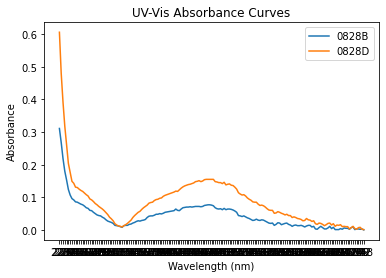

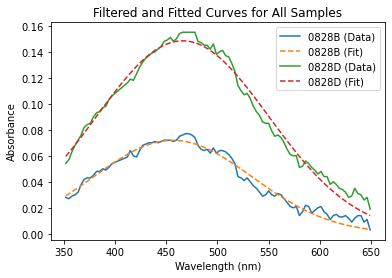

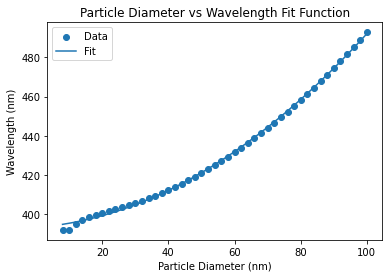

For 0828B, Peak Wavelength: 456.4104 nm, FWHM: 258.9292 nm, Estimated Diameter: 78.56 nm, PDI: 12.7771 nm
For 0828D, Peak Wavelength: 466.0004 nm, FWHM: 280.7987 nm, Estimated Diameter: 84.81 nm, PDI: 10.9611 nm


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar

# Define Gaussian function for curve fitting
def gaussian(x, height, center, width):
    return height * np.exp(-((x - center) / width) ** 2)

# Function to fit the data to (for example, a polynomial of 2nd degree)
def fit_function(x, a, b, c):
    return a * x ** 2 + b * x + c

# Function to predict particle diameter based on the fitted curve
def predict_particle_diameter(peak_wavelength, fit_parameters):
    a, b, c = fit_parameters
    discriminant = b ** 2 - 4 * a * (c - peak_wavelength)
    if discriminant < 0:
        return "No real root"
    root1 = (-b + np.sqrt(discriminant)) / (2 * a)
    root2 = (-b - np.sqrt(discriminant)) / (2 * a)
    return min(root1, root2) if root1 >= 0 and root2 >= 0 else root1 if root1 >= 0 else root2 if root2 >= 0 else "No physical solution"

# Function to load the UV-Vis dataset from the given file path
def load_uv_vis_data(file_path):
    reading_data = False
    header = None
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if reading_data:
                data.append([float(part) if part.replace('.', '', 1).isdigit() else part for part in parts])
            else:
                if sum(part.replace('.', '', 1).isdigit() for part in parts) > len(parts) / 2:
                    reading_data = True
                    header = parts
    df = pd.DataFrame(data, columns=header)
    df.dropna(axis=1, how='all', inplace=True)
    return df

# Function to find the root (inverse) of the quadratic fit to get particle size from wavelength
def root_function(x, wavelength, a, b, c):
    return a * x ** 2 + b * x + c - wavelength

# Load the dataset for UV-Vis
file_path = 'C:\\Users\\ryanv\\OneDrive\\Desktop\\SilverGrowthReport2.txt'  # Update this path to your actual file path
df = load_uv_vis_data(file_path)

# Initialize a dictionary to store the data for each sample
sample_data = {}

# Transpose the DataFrame
df_transposed = df.drop(columns=df.columns[df.dtypes != 'float64']).transpose()
df_transposed.columns = df['Sample ID']
df_transposed.reset_index(inplace=True)
df_transposed.rename(columns={'index': 'Wavelength'}, inplace=True)

# Plot UV-Vis absorbance curves for all samples
plt.figure()
for column in df_transposed.columns[1:]:  # Skip the first column assuming it's Wavelength
    plt.plot(df_transposed['Wavelength'], df_transposed[column], label=column)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.legend()
plt.title('UV-Vis Absorbance Curves')
plt.show()

# Filter dataset for values between 350 nm and 650 nm
filtered_dfs = {}
peak_wavelengths = []
plt.figure()
for column in df_transposed.columns[1:]:  # Skip the first column assuming it's Wavelength
    filtered_dfs[column] = df_transposed[(df_transposed['Wavelength'].astype(float) >= 350) & (df_transposed['Wavelength'].astype(float) <= 650)]
    initial_guess = [1, filtered_dfs[column]['Wavelength'].astype(float).mean(), 20]
    try:
        params, _ = curve_fit(gaussian, filtered_dfs[column]['Wavelength'].astype(float), filtered_dfs[column][column], p0=initial_guess)
        height, center, width = params
        FWHM = 2.35482 * width  # 2 * sqrt(2 * ln(2)) * width
        peak_wavelengths.append(center)
        plt.plot(filtered_dfs[column]['Wavelength'].astype(float), filtered_dfs[column][column], label=f'{column} (Data)')
        plt.plot(filtered_dfs[column]['Wavelength'].astype(float), gaussian(filtered_dfs[column]['Wavelength'].astype(float), *params), '--', label=f'{column} (Fit)')
        # Store the computed values in the sample_data dictionary
        sample_data[column] = {
            'Peak Wavelength': center,
            'FWHM': FWHM
        }
    except Exception as e:
        print(f"Could not fit curve for {column}. Error: {e}")

plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.legend()
plt.title('Filtered and Fitted Curves for All Samples')
plt.show()

# Your manually entered data for particle diameters and wavelengths
particle_diameters = np.concatenate([np.array([8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54]),
                                     np.array([56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100])])
wavelengths = np.concatenate([np.array([392.0, 392.1, 395.2, 397.2, 398.5, 399.7, 400.8, 401.6, 402.5, 403.5, 404.5, 405.6, 406.8, 408.1, 409.4, 410.8, 412.3, 413.9, 415.5, 417.3, 419.1, 420.9, 422.9, 424.9]),
                              np.array([427.0, 429.2, 431.5, 433.8, 436.2, 438.7, 441.3, 443.8, 446.7, 449.5, 452.3, 455.3, 458.3, 461.4, 464.6, 467.9, 471.2, 474.6, 478.1, 481.6, 485.3, 489.0, 492.8])])

# Fitting particle diameters
params, _ = curve_fit(fit_function, particle_diameters, wavelengths)

# Plot the fit for particle diameter vs wavelength
plt.figure()
plt.scatter(particle_diameters, wavelengths, label='Data')
x_fit = np.linspace(min(particle_diameters), max(particle_diameters), 500)
y_fit = fit_function(x_fit, *params)
plt.plot(x_fit, y_fit, label='Fit')
plt.xlabel('Particle Diameter (nm)')
plt.ylabel('Wavelength (nm)')
plt.legend()
plt.title('Particle Diameter vs Wavelength Fit Function')
plt.show()

# Predict particle diameters based on the peak wavelengths
for column, peak in zip(df_transposed.columns[1:], peak_wavelengths):
    estimated_diameter = predict_particle_diameter(peak, params)
    # Update the sample_data dictionary with the estimated diameter
    if column in sample_data:
        sample_data[column]['Estimated Diameter'] = estimated_diameter

# Initialize lists to collect estimated mean sizes and widths
estimated_mean_sizes = []
estimated_FWHMs = []

# Calculate the polydispersity index for each Gaussian fit
for i, column in enumerate(df_transposed.columns[1:]):
    try:
        # Estimated mean particle size using root of quadratic function
        wavelength = peak_wavelengths[i]
        estimated_mean_size = root_scalar(root_function, args=(wavelength, *params), bracket=[1, 100]).root
        estimated_mean_sizes.append(estimated_mean_size)

        # Estimated particle size width from FWHM of Gaussian
        FWHM = 2.35482 * width  # 2 * sqrt(2 * ln(2)) * width
        estimated_FWHMs.append(FWHM)

        # Calculate and store polydispersity index in the sample_data dictionary
        PDI = (FWHM ** 2) / (estimated_mean_size ** 2)
        if column in sample_data:
            sample_data[column]['PDI'] = PDI
    except Exception as e:
        print(f"Could not calculate PDI for {column}. Error: {e}")

# Output the aggregated data for each sample
for column, data in sample_data.items():
    print(f"For {column}, "
          f"Peak Wavelength: {data['Peak Wavelength']:.4f} nm, "
          f"FWHM: {data['FWHM']:.4f} nm, "
          f"Estimated Diameter: {data['Estimated Diameter']:.2f} nm, "
          f"PDI: {data['PDI']:.4f} nm")
